In [1]:
from glob import glob
import shutil
import os
import json
import random
import cv2
import matplotlib.pyplot as plt

In [ ]:
import supervision as sv
sv.create_tiles()

In [2]:
# prepare the dataset
dataset_path = "/Users/huynhanhkiet/Desktop/Object_Detection/ArTaxOr/notebooks/data"
final_dataset_path = "/Users/huynhanhkiet/Desktop/Object_Detection/ArTaxOr/notebooks/coco/"
final_annots_path = os.path.join(final_dataset_path, 'annotations')
final_images_path = os.path.join(final_dataset_path, 'images')
final_labels_path = os.path.join(final_dataset_path, 'labels')

In [3]:
# create the directories for the dataset
os.makedirs(final_annots_path, exist_ok=True)
os.makedirs(final_images_path, exist_ok=True)
os.makedirs(final_labels_path, exist_ok=True)

os.makedirs(f'{final_dataset_path}/train', exist_ok=True)
os.makedirs(f'{final_dataset_path}/valid', exist_ok=True)
os.makedirs(f'{final_dataset_path}/test', exist_ok=True)

In [4]:
# get the subdirs, every single one of them represents another label and contains the data for that label.
subdir_paths = glob(os.path.join(dataset_path, "*"))
# filter out the files that are not directories
subdir_paths = list(filter(os.path.isdir, subdir_paths))

labels = [path.split("/")[-1] for path in subdir_paths]
annot_file_paths = []

In [5]:
# get the annotation files, we will use these to extract the information about the images
for subdir in subdir_paths:
    annot_file_paths += glob(os.path.join(subdir, 'annotations', '*.json'))

# shuffle the paths so we won't need to randomize them again while splitting the dataset
# random.shuffle(annot_file_paths)
# map labels to integers
labels_to_idx = {label: idx for idx, label in enumerate(labels, 0)}

In [6]:
labels_to_idx

{'Hemiptera': 0, 'Coleoptera': 1}

In [7]:
# loop through the annotations files and collect the required data for
# mapping the dataset to COCO format
ANNOT_ID = 1
IMAGE_ID = 1

# these are required for annotations.json
annotations = []
images = []
categories = []

# this one is for the {image_name}.json files
samples = []

# start the process by filling the categories first, because it's much easier :D
for label, idx in labels_to_idx.items():
    pair = {}

    pair['id'] = idx
    pair['name'] = label

    categories.append(pair)

In [8]:
# now we can continue with rest
for annot_path in annot_file_paths:
    with open(annot_path, "r") as f:
        data = json.load(f)

    # metadata about the image
    asset = data.get('asset')
    if not asset: raise Exception(f"There's no 'asset' key in the sample: {annot_path}")

    name = asset['name']
    width = asset['size']['width']
    height = asset['size']['height']
    label = asset['path'].split("/")[-2]

    # regions located in the image
    regions = data.get('regions')
    if not regions: raise Exception(f"There's no 'regions' key in the sample: {annot_path}")

    # these will be used to fill the annotation file and sample entry
    shapes = []
    for reg in regions:
        shape_type = str.lower(reg['type'])

        tag = [t for t in reg['tags'] if t in labels]
        if tag:
            tag = tag[0]

            subtags = [t for t in reg['tags'] if not (t in labels)]
            sample_label = labels_to_idx[tag]
            
            # get the bbox as top left x, top left y, width, height
            bbox_h = reg['boundingBox']['height']
            bbox_w = reg['boundingBox']['width']
            bbox_x = reg['boundingBox']['left']
            bbox_y = reg['boundingBox']['top']
            bbox = [bbox_x, bbox_y, bbox_w, bbox_h]

            # calculate the bbox area
            area = bbox_w*bbox_h

            shapes.append({
                'iscrowd': 0,
                'category_id': sample_label,
                'id': ANNOT_ID,
                'image_id': IMAGE_ID,
                'area': area,
                'bbox': bbox,
                'category_name': tag,
                'tags': subtags,
                'shape_type': shape_type
            })

            ANNOT_ID += 1
        else:
            continue

    # add the shapes to the annotations list
    annotations.extend(shapes)
    ###
    # move on to the sample, this will be stored as {image_name}.json
    # in the labels directory
    sample = {}
    sample['version'] = data['version']
    sample['flags'] = {}
    # absolute path for the image path
    new_name = f"{label}_{name}"
    new_name_wo_ext = new_name.split(".")[0]
    sample['imagePath'] = os.path.join(final_images_path, new_name)

    sample['imageData'] = None
    sample['imageHeight'] = height
    sample['imageWidth'] = width
    # construct the shapes
    sample['shapes'] = []
    for shape in shapes:
        category_name = shape['category_name']
        bbox = shape['bbox']
        shape_type = shape['shape_type']

        sample_dict = {
            'label': category_name,
            'points':
            [
                [bbox[0], bbox[1]],
                [bbox[0] + bbox[2], bbox[1] + bbox[3]],
            ],
            'group_id': None,
            'shape_type': shape_type,
            'flags': {}
        }
        sample['shapes'].append(sample_dict)
    # append the sample to the samples list
    samples.append(sample)

    # we also need to fill the 'images' key in the annotations file, it requires much less keys
    images.append(
        {
            'height': sample['imageHeight'],
            'width': sample['imageWidth'],
            'id': IMAGE_ID,
            'file_name': new_name
        }
    )

    IMAGE_ID += 1

    # copy the image to the target location and create their label files
    with open(os.path.join(final_labels_path, new_name_wo_ext + ".json"), "w") as f:
        json.dump(sample, f)

    image_source_path = os.path.join(dataset_path, label, name)
    image_dest_path = os.path.join(final_images_path, new_name)
    shutil.copy(image_source_path, image_dest_path)

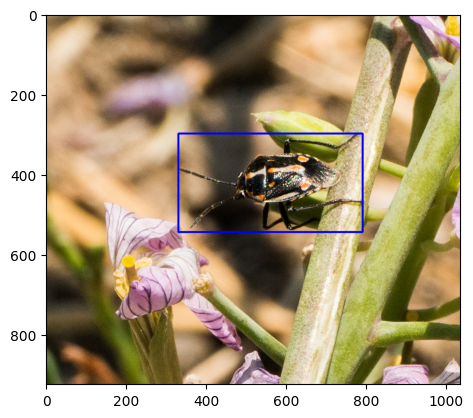

In [9]:
# test to see if we did it correctly
# get the first image from samples with bboxes
first_sample = samples[0]
bbox = first_sample['shapes'][0]['points']

img = cv2.cvtColor(cv2.imread(first_sample['imagePath']), cv2.COLOR_BGR2RGB)

img = cv2.rectangle(img,(int(bbox[0][0]), int(bbox[0][1])), (int(bbox[1][0]), int(bbox[1][1])), (0, 0, 255), 3)

plt.imshow(img)

In [10]:
categories

[{'id': 0, 'name': 'Hemiptera'}, {'id': 1, 'name': 'Coleoptera'}]

In [11]:
# construct the annotation file
annotations_dict = {
    "images": images,
    "categories": categories,
    "annotations": annotations
}

In [12]:
# save the annotations file
with open(os.path.join(final_annots_path, 'annotations_all.json'), "w") as f:
    json.dump(annotations_dict, f)

In [13]:
# a simple sanity check
with open(os.path.join(final_annots_path, 'annotations_all.json'), "r") as f:
    annotations_dict_loaded = json.load(f)

annotations_dict_loaded.keys()

dict_keys(['images', 'categories', 'annotations'])

In [14]:
# it's better to process the splitting part with parallel processing since I'll 
# pretty much do a linear search.
from joblib import Parallel, delayed

In [15]:
# pick the images and then gather the annotations and categories
def get_annotations(images):
    found_annots = []

    def search_annot(img_entry):
        image_id = img_entry['id']
        entry_annots = []
        for annot in annotations:
            if annot['image_id'] == image_id:
                entry_annots.append(annot)
        return entry_annots

    results = Parallel(n_jobs=-1)(delayed(search_annot)(img_entry) for img_entry in images)

    for res in results:
        found_annots.extend(res)

    return found_annots

In [16]:
# create the training, validation and test splits
N = len(images)
N_train = int(N * 0.8) # use the 80% of the total samples for training
N_valid = (N - N_train) // 2 # split the remaining 20% to half for testing and validation
N_test = N - N_train - N_valid

print("Using 80% of the data as training set, 10% for validation and 10% for testing set")
print("Total training samples:", N_train)
print("Total validation samples:", N_valid)
print("Total test samples:", N_test)
print("Split sum: ", N_train+N_valid+N_test)
print("Total samples:", N)

def get_categories(annots):
    labels = []
    for annot in annots:
        cat = annot.get('category_name')
        if cat not in labels:
            labels.append(cat)

    return [{"id": labels_to_idx[l], "name": l} for l in sorted(labels)]

# now start with training set
training_images = images[:N_train]
training_annotation_entries = get_annotations(training_images)
training_categories = get_categories(training_annotation_entries)
training_annotations = {
    "images": training_images,
    "categories": training_categories,
    "annotations": training_annotation_entries
}
for img in training_images:
    shutil.copy(f"{final_images_path}/{img['file_name']}", f"{final_dataset_path}/train")
with open(os.path.join(f"{final_dataset_path}/train", "_annotations.coco.json"), "w") as f:
    json.dump(training_annotations, f)

# validation
validation_images = images[N_train:(N_train + N_valid)]
validation_annotation_entries = get_annotations(validation_images)
validation_categories = get_categories(validation_annotation_entries)
validation_annotations = {
    "images": validation_images,
    "categories": validation_categories,
    "annotations": validation_annotation_entries
}
for img in validation_images:
    shutil.copy(f"{final_images_path}/{img['file_name']}", f"{final_dataset_path}/valid")
with open(os.path.join(f"{final_dataset_path}/valid", "_annotations.coco.json"), "w") as f:
    json.dump(validation_annotations, f)

# test
test_images = images[(N_train + N_valid):]
test_annotation_entries = get_annotations(test_images)
test_categories = get_categories(test_annotation_entries)
test_annotations = {
    "images": test_images,
    "categories": test_categories,
    "annotations": test_annotation_entries
}
for img in test_images:
    shutil.copy(f"{final_images_path}/{img['file_name']}", f"{final_dataset_path}/test")
with open(os.path.join(f"{final_dataset_path}/test", "_annotations.coco.json"), "w") as f:
    json.dump(test_annotations, f)

Using 80% of the data as training set, 10% for validation and 10% for testing set
Total training samples: 3597
Total validation samples: 450
Total test samples: 450
Split sum:  4497
Total samples: 4497


In [17]:
# also save the classes
class_with_id_text = "\n".join([f"{v} {k}" for k,v in labels_to_idx.items()])

with open(os.path.join(final_dataset_path, 'class_with_id.txt'), "w") as f:
    f.write(class_with_id_text)